In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay

In [2]:
EXAM_NAMES = ['Kuis 2', 'UTS']
EXAM_NUMBERS = {
    'Kuis 2': ['IA', 'IB', 'IC'],
    'UTS': ['IA', 'IB']
}
EXAMS = []
for exam_name in EXAM_NAMES:
    for exam_number in EXAM_NUMBERS[exam_name]:
        EXAMS.append((exam_name, exam_number))

LB = {
    'All': 0.6562801963,
    'Kuis 2 IA': 0.1447276516,
    'Kuis 2 IB': 0.3178719202,
    'Kuis 2 IC': 0.6346878475,
    'UTS IA': 0.5107134316,
    'UTS IB': 0.4047760493
}

X_AXIS = 'nilai autograder'
Y_AXIS = 'nilai manual'
EPS = 0.001

import os 
import sys

module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path) 
    
from grader.src.ged.classes.general_cost_function import RelabelMethod
from grader.src.grader import Grader, GraphPreprocessType

REAL_GRADE_FILENAME = 'Real Results.csv'
BENCHMARK = ''

real_dataframe = pd.read_csv(REAL_GRADE_FILENAME)
dataframes = {}
for node_cost in range(1, 4):
    for edge_cost in range(1, 4):
        if node_cost == edge_cost and node_cost != 1:
            continue
        for relabel_method in RelabelMethod.__iter__():
            for graph_preprocess_type in GraphPreprocessType.__iter__():
                for time_limit in [1000, 3000, 10000, 50000]:
                    filename = f'Time Data_{relabel_method.name}_{graph_preprocess_type.name}_{time_limit}_C{node_cost}{edge_cost}.csv'
                    if filename not in os.listdir('./'):
                        continue
                    BENCHMARK = filename
                    dataframes[filename] = pd.read_csv(filename).rename(columns={'grade': 'nilai autograder'})
                    dataframes[filename] = pd.merge(dataframes[filename], real_dataframe, on=['nim', 'exam_name', 'number'])

SENDJAJA = 'Grade Results.csv'
dataframes[SENDJAJA] = pd.read_csv(SENDJAJA).rename(columns={'grade': 'nilai autograder'})
dataframes[SENDJAJA] = pd.merge(dataframes[SENDJAJA], real_dataframe, on=['nim', 'exam_name', 'number'])


# relabel_method = RelabelMethod.BOOLEAN_COUNT
# graph_preprocess_type = GraphPreprocessType.UNCOLLAPSE
# filename = f'Test Coef_{relabel_method.name}_{graph_preprocess_type.name}.csv'
# if filename in os.listdir('./'):
#     dataframes[filename] = pd.read_csv(filename).rename(columns={'grade': 'nilai autograder'})
#     dataframes[filename] = pd.merge(dataframes[filename], real_dataframe, on=['nim', 'exam_name', 'number'])

In [3]:
# Correlation function
def correlation(df):
    return df.corr()

In [4]:
# MAE (Mean Absolute Error) function
def mae(df):
    return mean_absolute_error(df[X_AXIS], df[Y_AXIS])

In [5]:
# Linear Regression Plot function
def linear_regression_plot(name, df):
    m, b = np.polyfit(df[X_AXIS], df[Y_AXIS], 1)
    print(f'Info for plot={name}: m={m}, b={b}')
    fig, ax = plt.subplots(figsize=(8, 8), dpi=60)
    ax.scatter(df[X_AXIS], df[Y_AXIS])
    ax.set_title(f'Perbandingan Hasil Penilaian Menggunakan Sistem Autograder\n dan Hasil Penilaian Manual oleh Pendidik\n{name}')
    ax.set_xlabel('Hasil Penilaian Menggunakan Sistem Autograder')
    ax.set_ylabel('Hasil Penilaian Manual oleh Pendidik')
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 100])
    ax.set_aspect(1)
    ax.plot(df[Y_AXIS], m * df[Y_AXIS] + b)
    plt.show()

In [6]:
# Confusion Matrix Plot function
def confusion_matrix_plot(name, df):
    bins = [10 * x - EPS for x in range(11)] + [100 + EPS]
    labels = range(11)

    cat_X = pd.cut(df[X_AXIS], bins=bins, labels=labels)
    cat_Y = pd.cut(df[Y_AXIS], bins=bins, labels=labels)
    categorized_grade = pd.concat([cat_X, cat_Y], axis=1)
    
    cm = confusion_matrix(categorized_grade[X_AXIS], categorized_grade[Y_AXIS], labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(10, 8), dpi=60)
    ax.set_title(f'Confusion Matrix Perbandingan Hasil Penilaian Menggunakan Sistem Autograder\n dan Hasil Penilaian Manual oleh Pendidik\n{name}')
    disp.plot(ax=ax)
    disp.ax_.set(xlabel=X_AXIS, ylabel=Y_AXIS)
    plt.show()

In [7]:
# Histogram Difference Plot Function
def histogram_dif_plot(name, df):
    n, bins, patches = plt.hist(x=df, bins='auto', rwidth=0.75)
    plt.grid(axis='y', alpha=0.80)
    plt.title(f'Histogram Perbedaan Nilai Autograder dengan Nilai Manual\n{name}')
    plt.xlabel('Nilai Perbedaan = Nilai Autograder - Nilai Manual')
    plt.ylabel('Frekuensi')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    plt.show()

In [8]:
# persentase yang is_guaranteed_optimal
TIME = 'time_spent'
OPT = 'is_guaranteed_optimal'
NODE = 'node_count2'

def time_analysis(name, df):
    if TIME not in df.columns:
        return
    
    print(f'Analisis Waktu {name}')
    result = {}
    result['All'] = len(df.loc[df[OPT] == True]) / len(df) * 100
    for exam_name, number in EXAMS:
        cur_df = df.loc[(df['exam_name'] == exam_name) & (df['number'] == number)]
        result[f'{exam_name} {number} ({cur_df.iloc[0][NODE]})'] = len(cur_df.loc[cur_df[OPT] == True]) / len(cur_df) * 100
        
    for k, v in result.items():
        print(f'{k: <20}: {round(v, 2)}%')
    print('-----\n')
    
def accuracy(name, df1, df2):
    if TIME not in df.columns:
        return
    
    print(f'Analisis Akurasi {name}')
    acc = {}
    acc['All'] = np.average(df1[X_AXIS] / df2[X_AXIS]) * 100
    for exam_name, number in EXAMS:
        cur_df1 = df1.loc[(df1['exam_name'] == exam_name) & (df1['number'] == number)]
        cur_df2 = df2.loc[(df2['exam_name'] == exam_name) & (df2['number'] == number)]
        acc[f'{exam_name} {number} ({cur_df1.iloc[0][NODE]})'] = np.average(cur_df1[X_AXIS] / cur_df2[X_AXIS]) * 100
    
    for k, v in acc.items():
        print(f'{k: <20}: {round(v, 2)}%')
    print('-----\n')

In [9]:
for name, df in dataframes.items():
    time_analysis(name, df)

Analisis Waktu Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv
All                 : 45.08%
Kuis 2 IA (8)       : 87.18%
Kuis 2 IB (24)      : 0.0%
Kuis 2 IC (28)      : 0.0%
UTS IA (12)         : 28.57%
UTS IB (7)          : 92.86%
-----

Analisis Waktu Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv
All                 : 53.03%
Kuis 2 IA (8)       : 99.15%
Kuis 2 IB (24)      : 0.0%
Kuis 2 IC (28)      : 1.64%
UTS IA (12)         : 71.43%
UTS IB (7)          : 92.86%
-----

Analisis Waktu Time Data_BOOLEAN_COUNT_UNCOLLAPSE_10000_C31.csv
All                 : 55.68%
Kuis 2 IA (8)       : 100.0%
Kuis 2 IB (24)      : 0.0%
Kuis 2 IC (28)      : 8.2%
UTS IA (12)         : 78.57%
UTS IB (7)          : 100.0%
-----

Analisis Waktu Time Data_BOOLEAN_COUNT_UNCOLLAPSE_50000_C31.csv
All                 : 56.82%
Kuis 2 IA (8)       : 100.0%
Kuis 2 IB (24)      : 0.0%
Kuis 2 IC (28)      : 8.2%
UTS IA (12)         : 100.0%
UTS IB (7)          : 100.0%
-----



In [10]:
for name, df in dataframes.items():
    accuracy(name, df, dataframes[BENCHMARK])

Analisis Akurasi Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv
All                 : 93.59%
Kuis 2 IA (8)       : 99.98%
Kuis 2 IB (24)      : 87.63%
Kuis 2 IC (28)      : 84.09%
UTS IA (12)         : 99.75%
UTS IB (7)          : 100.0%
-----

Analisis Akurasi Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv
All                 : 93.65%
Kuis 2 IA (8)       : 100.0%
Kuis 2 IB (24)      : 87.63%
Kuis 2 IC (28)      : 84.26%
UTS IA (12)         : 100.0%
UTS IB (7)          : 100.0%
-----

Analisis Akurasi Time Data_BOOLEAN_COUNT_UNCOLLAPSE_10000_C31.csv
All                 : 96.13%
Kuis 2 IA (8)       : 100.0%
Kuis 2 IB (24)      : 97.49%
Kuis 2 IC (28)      : 85.64%
UTS IA (12)         : 100.0%
UTS IB (7)          : 100.0%
-----

Analisis Akurasi Time Data_BOOLEAN_COUNT_UNCOLLAPSE_50000_C31.csv
All                 : 100.0%
Kuis 2 IA (8)       : 100.0%
Kuis 2 IB (24)      : 100.0%
Kuis 2 IC (28)      : 100.0%
UTS IA (12)         : 100.0%
UTS IB (7)          : 100.0%
-----



In [11]:
# Print Correlations
all_correls = {}
correls = []
for name, df in dataframes.items():
    corr = correlation(df)
    correls.append((corr[X_AXIS][Y_AXIS], name))
    all_correls[name] = {}
    all_correls[name]['All'] = corr[X_AXIS][Y_AXIS]
    
correls.sort(key=lambda x: -x[0])
for corr, name in correls:
    print(f'{name}: {corr}')

Time Data_BOOLEAN_COUNT_UNCOLLAPSE_10000_C31.csv: 0.7439454211956821
Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv: 0.7356135703050806
Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv: 0.7353256828173592
Time Data_BOOLEAN_COUNT_UNCOLLAPSE_50000_C31.csv: 0.7072274466469459
Grade Results.csv: 0.6562801963372779


In [12]:
exam_correls = {}
for exam in EXAMS:
    exam_correls[exam] = []
    for _, name in correls:
        df = dataframes[name]
        corr = correlation(df.loc[(df['exam_name'] == exam[0]) & (df['number'] == exam[1])])
        exam_correls[exam].append((corr[X_AXIS][Y_AXIS], name))
        all_correls[name][f'{exam[0]} {exam[1]}'] = corr[X_AXIS][Y_AXIS]
    exam_correls[exam].sort(reverse=True)
    
for exam in EXAMS:
    print('-----')
    for corr, name in exam_correls[exam][:10]:
        print(f'{exam} {name}: {corr}')
    print('-----\n')
# for _, name in correls[90: 120]:
#     df = dataframes[name]
#     for exam in EXAMS:
#         corr = correlation(df.loc[(df['exam_name'] == exam[0]) & (df['number'] == exam[1])])
#         print(f'{exam} {name}:\n {corr[X_AXIS][Y_AXIS]}', '\n-----\n')

-----
('Kuis 2', 'IA') Grade Results.csv: 0.14472765155427839
('Kuis 2', 'IA') Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv: -0.003992004157238556
('Kuis 2', 'IA') Time Data_BOOLEAN_COUNT_UNCOLLAPSE_50000_C31.csv: -0.0043141232744167745
('Kuis 2', 'IA') Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv: -0.0043141232744167745
('Kuis 2', 'IA') Time Data_BOOLEAN_COUNT_UNCOLLAPSE_10000_C31.csv: -0.0043141232744167745
-----

-----
('Kuis 2', 'IB') Time Data_BOOLEAN_COUNT_UNCOLLAPSE_10000_C31.csv: 0.6560239202192354
('Kuis 2', 'IB') Time Data_BOOLEAN_COUNT_UNCOLLAPSE_50000_C31.csv: 0.5642294061230818
('Kuis 2', 'IB') Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv: 0.5504421835372558
('Kuis 2', 'IB') Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv: 0.5504421835372558
('Kuis 2', 'IB') Grade Results.csv: 0.31787192021786037
-----

-----
('Kuis 2', 'IC') Time Data_BOOLEAN_COUNT_UNCOLLAPSE_50000_C31.csv: 0.6813085031180683
('Kuis 2', 'IC') Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv: 0.644

In [13]:
count_top = {}
for exam in EXAMS:
    for corr, name in exam_correls[exam]:
        if corr >= LB[f'{exam[0]} {exam[1]}'] * 0.8:
            if name not in count_top:
                count_top[name] = 0
            count_top[name] += 1
    
top_name = [x for x in count_top.items()]
top_name.sort(reverse=True, key=lambda x: (x[1], all_correls[x[0]]['All']))
vis = {}
for name, count in top_name:
    if count not in vis:
        vis[count] = 0
    if vis[count] >= 3:
        continue
    print(f'{name}: {count}')
    for exam, corr in all_correls[name].items():
        print(f'{exam}: {corr}')
    print()
    vis[count] += 1

Grade Results.csv: 5
All: 0.6562801963372779
Kuis 2 IA: 0.14472765155427839
Kuis 2 IB: 0.31787192021786037
Kuis 2 IC: 0.634687847477691
UTS IA: 0.5107134315754333
UTS IB: 0.40477604933116773

Time Data_BOOLEAN_COUNT_UNCOLLAPSE_10000_C31.csv: 3
All: 0.7439454211956821
Kuis 2 IA: -0.0043141232744167745
Kuis 2 IB: 0.6560239202192354
Kuis 2 IC: 0.6358663082937552
UTS IA: 0.4170501404458414
UTS IB: 0.13314526552241168

Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv: 3
All: 0.7356135703050806
Kuis 2 IA: -0.0043141232744167745
Kuis 2 IB: 0.5504421835372558
Kuis 2 IC: 0.644047063280291
UTS IA: 0.4170501404458414
UTS IB: 0.13314526552241168

Time Data_BOOLEAN_COUNT_UNCOLLAPSE_50000_C31.csv: 3
All: 0.7072274466469459
Kuis 2 IA: -0.0043141232744167745
Kuis 2 IB: 0.5642294061230818
Kuis 2 IC: 0.6813085031180683
UTS IA: 0.4170501404458414
UTS IB: 0.13314526552241168

Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv: 2
All: 0.7353256828173592
Kuis 2 IA: -0.003992004157238556
Kuis 2 IB: 0.55044218353

In [14]:
# Print MAE
# for name, df in dataframes.items():
#     print(f'MAE (Mean Absolute Error) of dataframe {name} exam: {mae(df)}')
    
maes = []
for name, df in dataframes.items():
    maes.append((mae(df), name))
maes.sort()
for mae, name in maes:
    print(f'{name}: {mae}')

Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv: 10.723020785599454
Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv: 10.725380462126546
Time Data_BOOLEAN_COUNT_UNCOLLAPSE_10000_C31.csv: 10.833485238365059
Time Data_BOOLEAN_COUNT_UNCOLLAPSE_50000_C31.csv: 12.099324723278365
Grade Results.csv: 13.108726565217047


Linear Regression Plot of Time Data_BOOLEAN_COUNT_UNCOLLAPSE_10000_C31.csv exam:
Info for plot=Time Data_BOOLEAN_COUNT_UNCOLLAPSE_10000_C31.csv: m=0.9321815911384604, b=0.3296687855230223


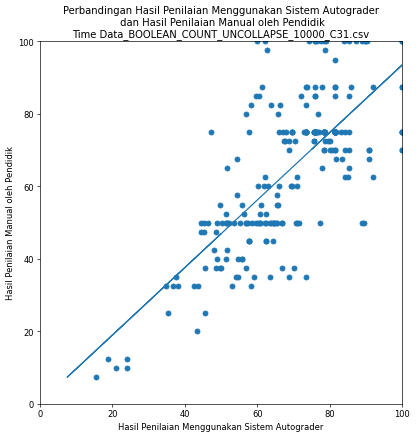

Linear Regression Plot of Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv exam:
Info for plot=Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv: m=0.8634715475431948, b=6.387840238890664


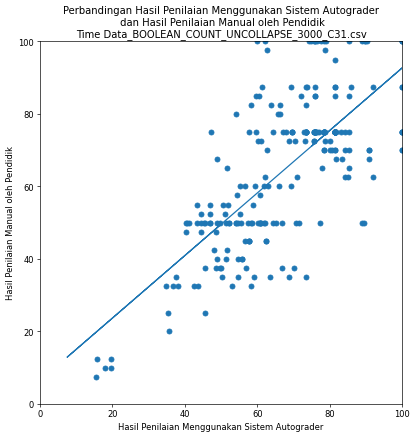

Linear Regression Plot of Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv exam:
Info for plot=Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv: m=0.8625567642341202, b=6.469185948561099


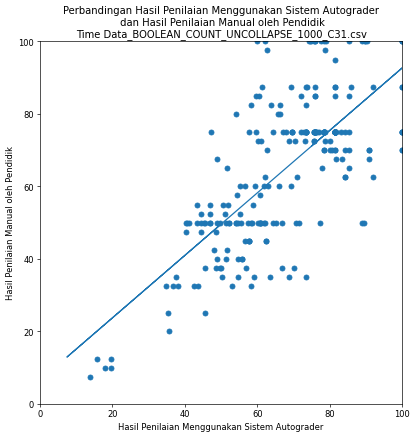

Linear Regression Plot of Time Data_BOOLEAN_COUNT_UNCOLLAPSE_50000_C31.csv exam:
Info for plot=Time Data_BOOLEAN_COUNT_UNCOLLAPSE_50000_C31.csv: m=0.9923307322529006, b=-6.389307688187327


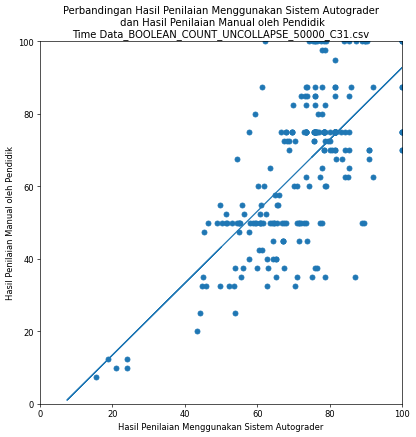

Linear Regression Plot of Grade Results.csv exam:
Info for plot=Grade Results.csv: m=0.6494050079710322, b=19.19245395383932


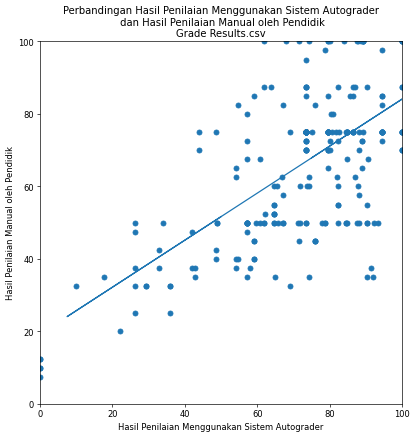

In [15]:
for _, name in correls[:10]:
    df = dataframes[name]
    print(f'Linear Regression Plot of {name} exam:')
    linear_regression_plot(name, df)

Confusion Matrix Plot of Grade Results.csv exam:


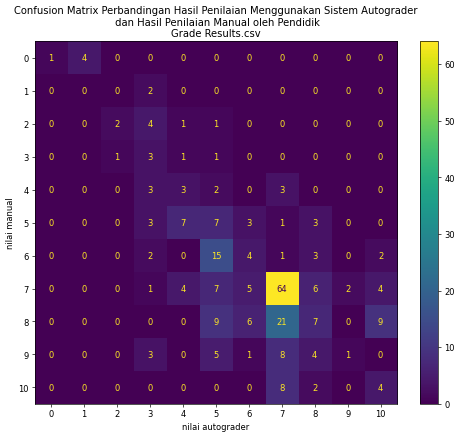

Confusion Matrix Plot of Time Data_BOOLEAN_COUNT_UNCOLLAPSE_10000_C31.csv exam:


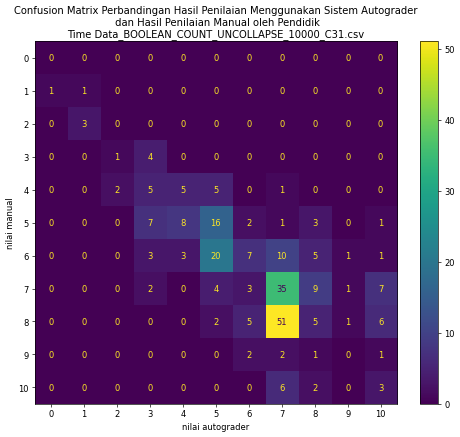

Confusion Matrix Plot of Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv exam:


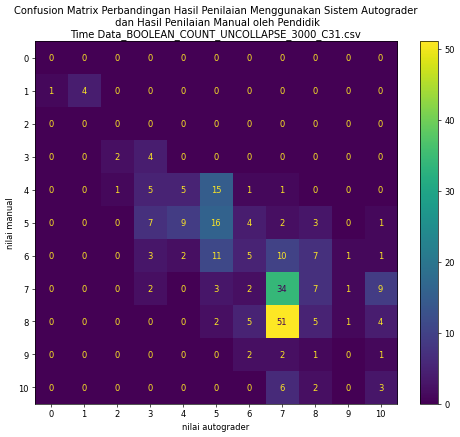

Confusion Matrix Plot of Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv exam:


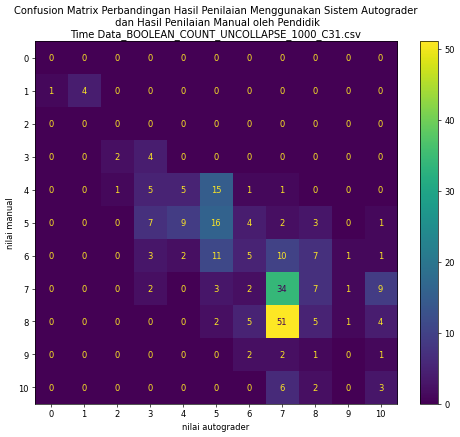

Confusion Matrix Plot of Time Data_BOOLEAN_COUNT_UNCOLLAPSE_50000_C31.csv exam:


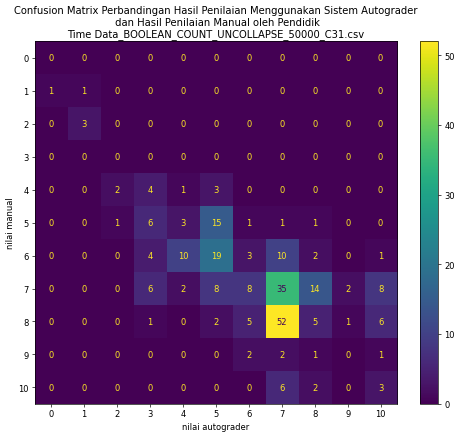

Confusion Matrix Plot of Grade Results.csv exam:


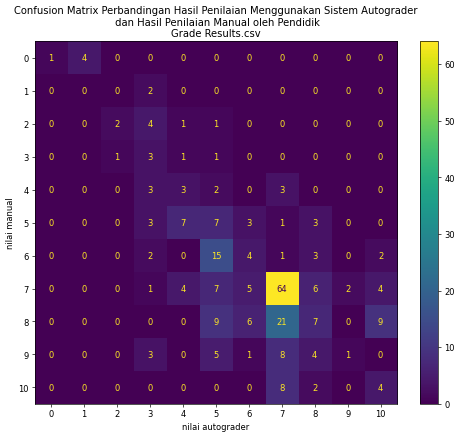

In [16]:
for _, name in [(all_correls[SENDJAJA]['All'], SENDJAJA)] + correls[:10]:
    df = dataframes[name]
    print(f'Confusion Matrix Plot of {name} exam:')
    confusion_matrix_plot(name, df)

Information on Difference of Time Data_BOOLEAN_COUNT_UNCOLLAPSE_10000_C31.csv exam:
Average 		:  4.422787356616894
Standard Deviation	:  13.18888665078114
Histogram Plot:


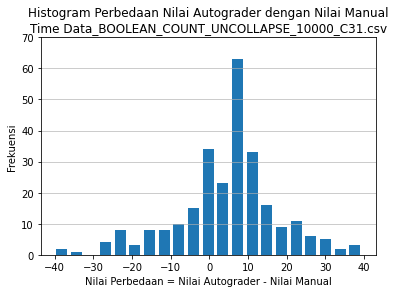

Information on Difference of Time Data_BOOLEAN_COUNT_UNCOLLAPSE_3000_C31.csv exam:
Average 		:  2.9829797057393814
Standard Deviation	:  13.521069566598431
Histogram Plot:


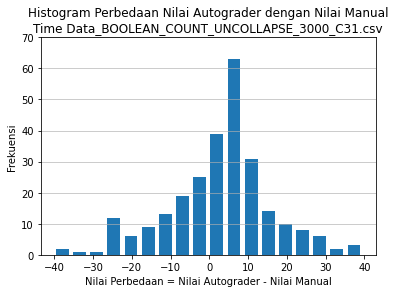

Information on Difference of Time Data_BOOLEAN_COUNT_UNCOLLAPSE_1000_C31.csv exam:
Average 		:  2.961464267482269
Standard Deviation	:  13.529992499150149
Histogram Plot:


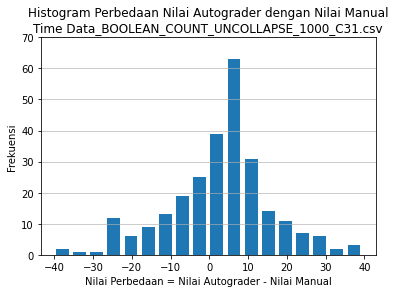

Information on Difference of Time Data_BOOLEAN_COUNT_UNCOLLAPSE_50000_C31.csv exam:
Average 		:  6.946092705772094
Standard Deviation	:  13.90847173621747
Histogram Plot:


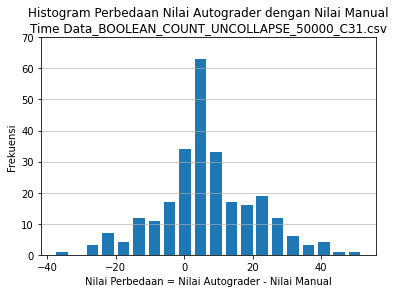

Information on Difference of Grade Results.csv exam:
Average 		:  5.890472719041822
Standard Deviation	:  16.398144169699133
Histogram Plot:


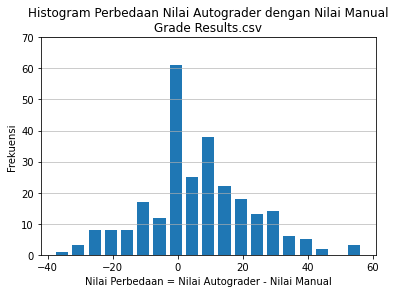

In [17]:
# Show Histogram Difference Plot
for corr, name in correls[:10]:
    df = dataframes[name]
    print(f'Information on Difference of {name} exam:')
    df_dif = df[X_AXIS] - df[Y_AXIS]
    print('Average \t\t: ', df_dif.mean())
    print('Standard Deviation\t: ', df_dif.std())
    print('Histogram Plot:')
    histogram_dif_plot(name, df_dif)